In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import h5py
from astropy.table import Table, join,join_skycoord
from fitsio import FITS

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from astropy.coordinates import SkyCoord
import astropy.units as u
plt.style.use('MNRAS.mplstyle')

# h = 0.7
zmin = 0.35
zmax = 0.5
filepath = r"/bsuhome/gladyskamau/BSU-Research/Cardinal/Data/"

## Load the halos

In [2]:
## Sigma and DS profile that have a match in Gold catalog
halos =  Table(np.load(filepath+"halos_cardinal_w_lensing_1687.npy"))
print(len(halos))
halos = halos[(halos['Redshift']>=zmin) & (halos['Redshift']<zmax)]
print(len(halos))
halos[:2]

648278
212485


haloid,Mvir,Rvir,M200m,R200m,rho,DeltaSigma,Sigma,ra,dec,Redshift,pixel_id,comoving_dis,Angular_dis,coadd_object_id
int64,float32,float64,float32,float64,float64[10],float64[15],float64[15],float32,float32,float64,int64,float64,float64,int64
9586022,52950000000000.0,855.544,0.0,0.0,0.0 .. 0.0,6.272749611329855e+24 .. 4.501470840232501e+23,0.0 .. 0.0,308.08777,-39.6392,0.35310322098959235,10029,974.0841993079198,719.886942272418,86001892766
9639931,131100000000000.0,1.174817042606516,137406700000000.0,1.2737,2708936233840203.0 .. 1086968953798.6124,8.121795036921167e+25 .. 1.5551437420973986e+24,1.668495980764465e+26 .. 8.241602207697279e+24,308.68823,-40.384052,0.421958,10158,1143.8806966508348,804.4395433299283,86001892689


In [3]:
### Load the halos with the DS and Sigma profiles, computed by ChunHao
halos =  Table(np.load(filepath+"correctfilev2.npy"))
print(len(halos))
print(halos.columns)
halos[:2]

1454571
<TableColumns names=('haloid','Mvir','RA','DEC','Redshift','Rvir','cosi','pid','rs','M200m','R200m','rho','DeltaSigma','Sigma','gtall','weightall','ratio','delta')>


haloid,Mvir,RA,DEC,Redshift,Rvir,cosi,pid,rs,M200m,R200m,rho,DeltaSigma,Sigma,gtall,weightall,ratio,delta
int32,float32,float64,float64,float64,float64,float64,int32,float64,float32,float64,float64[10],float64[15],float64[15],float64[15],float64[15],float64[100],float64[100]
12905996,1104000000000000.0,116.599,18.9969,0.62517,2.1563340659340655,0.464765,-1,0.377642,1129788000000000.0,2.57077,3232607803046852.0 .. 4951584885294.114,316.9408371320344 .. 6.325628131473273,2481.5244498274756 .. 30.791595507189847,-2.0638824814096005e-05 .. 0.6538981002611183,2.6673175421036414e-07 .. 0.0691232562888688,8.064741778139222 .. 1.0457879038100961,287.8731346185066 .. 5.31543402099229
35142654,963800000000000.0,12.3843,15.0544,0.62133,2.0602021978021976,0.673965,-1,0.409137,991244500000000.0,2.46113,1.1785172540359254e+16 .. 8011401459616.633,321.1758248373751 .. 4.446756445143821,2919.779680906132 .. 30.02479995711836,0.0 .. 0.1991121235725387,0.0 .. 0.06996756822056328,8.109481193785157 .. 1.0461027816248183,287.34227585727774 .. 5.351987610686462


In [4]:
'{:e}'.format(halos['Mvir'].min()), len(np.unique(halos['haloid']))

('1.001000e+13', 1449261)

In [5]:
## Load the HaloRun,similar to redmapper but no determined cluster center when running the redmapper algorithm
cluster_halo = Table(np.load(filepath+'HaloRun_Halo_Clusters_Lamgt20-20110.npy'))
print(len(cluster_halo))
cluster_halo = cluster_halo[(cluster_halo['z']>=zmin) & (cluster_halo['z']<=zmax)]
print(len(cluster_halo))
M200c = cluster_halo['m200'] 
lam = cluster_halo['lambda']

20110
3754


In [6]:
'{:e}'.format(cluster_halo['m200'].min())

'6.497000e+12'

In [7]:
## Let's define the cosmology parameters for colossus
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 70, 'Om0':0.286, 'Ob0': 0.047,'sigma8': 0.82, 'ns':0.96} # - gcosmology.Ob0
cosmo = cosmology.setCosmology('cosmo', params)

In [8]:
vol_hiMpc3 = (4607.50614163/(4*np.pi*((180/np.pi)**2)))*(4*np.pi/3)*((cosmo.comovingDistance(z_max=zmax))**3 - (cosmo.comovingDistance(z_max=zmin))**3)
vol_hiMpc3

674780525.4235318

(1e-08, 1e-05)

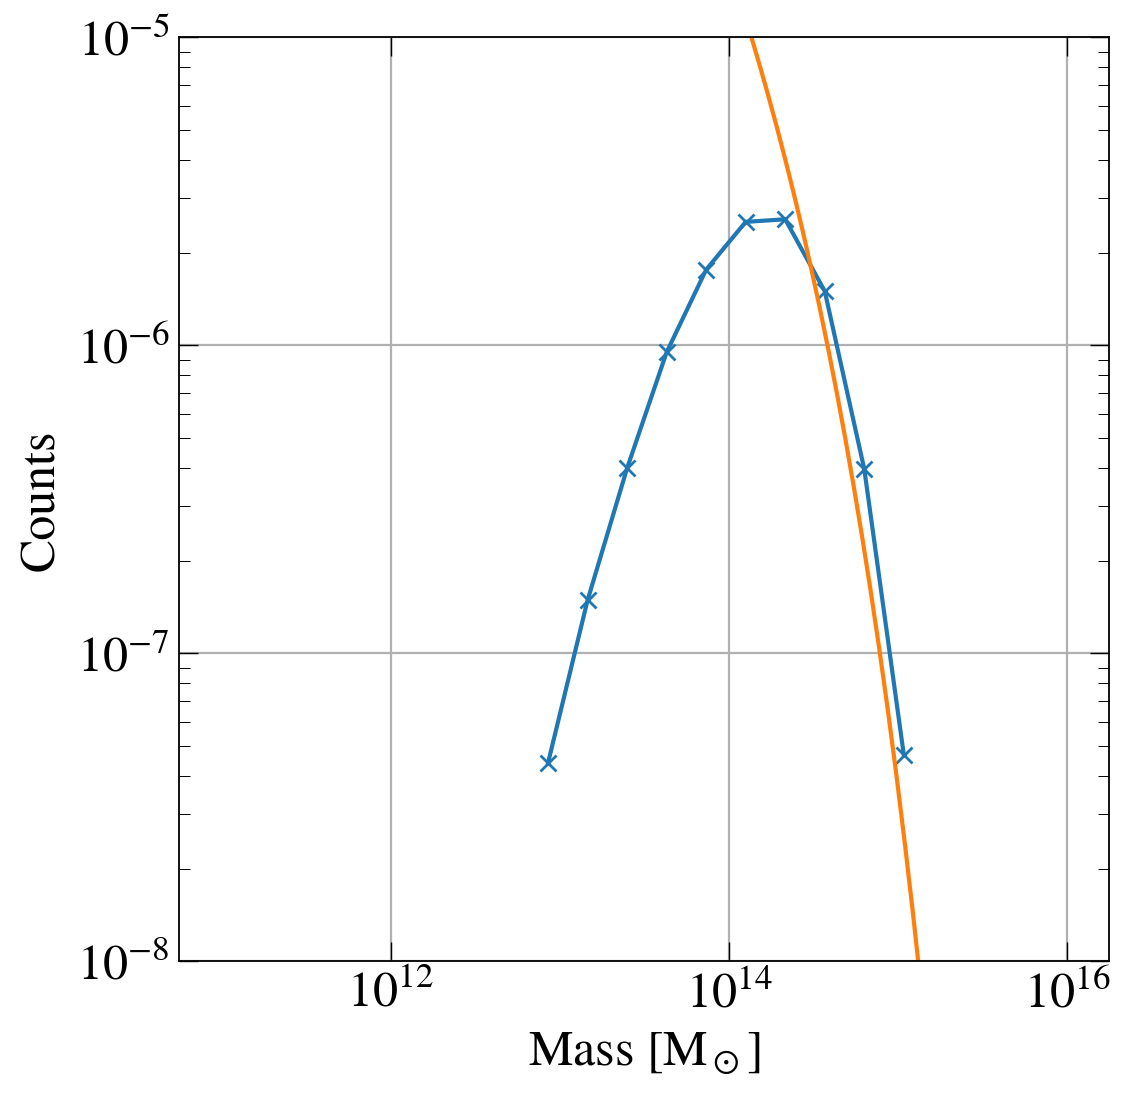

In [9]:
# # check the mass function
lnM_all = np.array(np.log(M200c))
counts, bins = np.histogram(lnM_all)
bins_mid = (bins[1:]+bins[:-1])/2.
counts = counts/(bins[1]-bins[0])
vol = vol_hiMpc3 #383945373.5961392 # 3167776723.771067 #1500**3  #??
plt.plot(np.exp(bins_mid), (counts/vol), marker='x')
plt.yscale('log')


from colossus.lss import mass_function
redshift =cluster_halo['z'].mean()
M_plot = np.logspace(11,16,100)
mfunc_200c = mass_function.massFunction(M_plot, redshift, q_out='dndlnM', 
    mdef = '200c', model = 'tinker08')
plt.plot(M_plot, mfunc_200c)

from scipy.interpolate import interp1d
lnMF_interp = interp1d(np.log(M_plot), np.log(vol*mfunc_200c))
plt.xlabel('Mass [M$_\odot$]')
plt.ylabel('Counts')
plt.xscale('log')
plt.ylim(1e-8, 1e-5)

3754


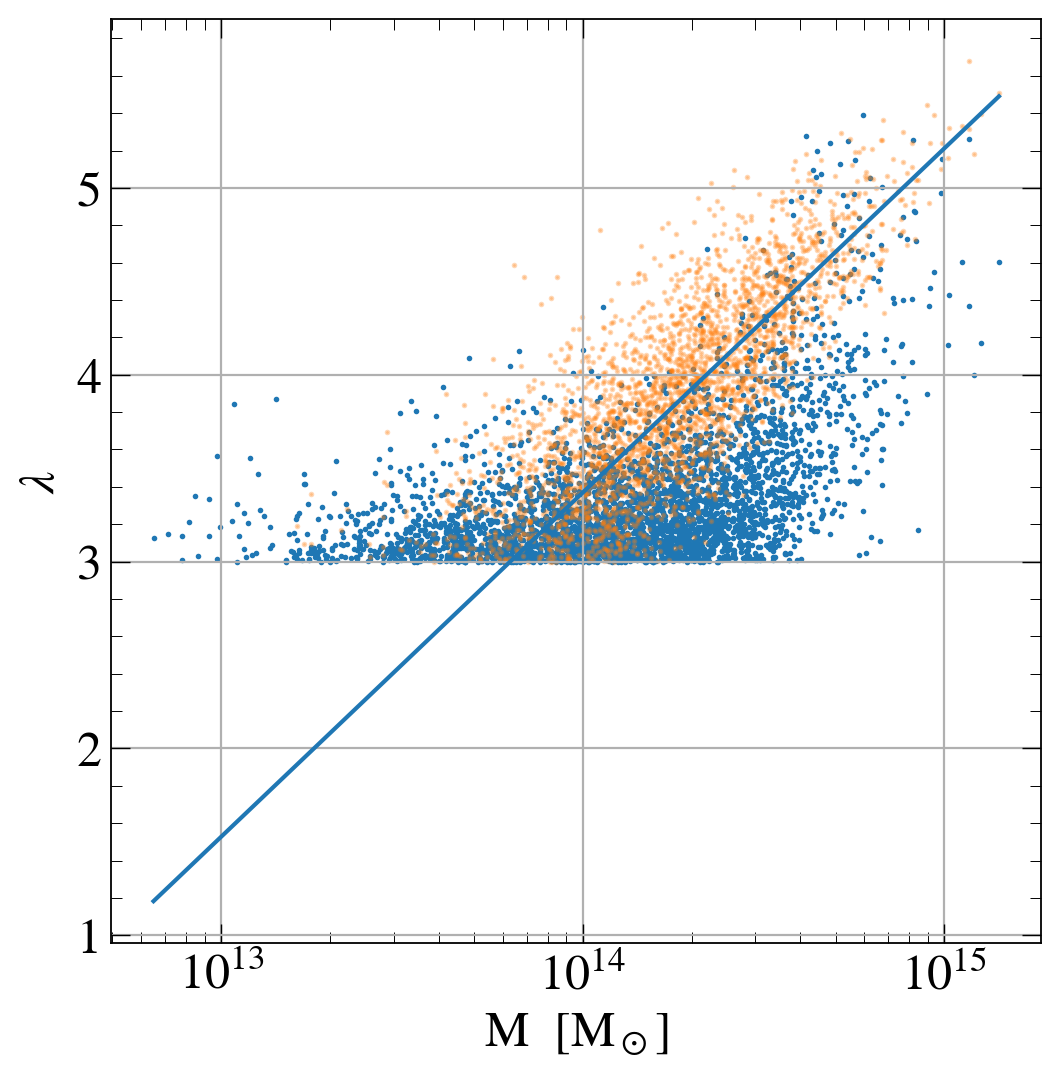

In [10]:
# plot richness-mass relation with a lambda 20 cut
lnMpivot = np.log(3e14)
lnlamth = np.log(20)

lnlam = np.log(lam)
ndata = len(lnM_all)
print(ndata)


def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam):
    plt.scatter(np.exp(lnM_all), lnlam, s=1)
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    plt.scatter(np.exp(lnM_mc), lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(min(lnM_all), max(lnM_all))
    plt.plot(np.exp(lnM_plot), intercept + slope * (lnM_plot - lnMpivot))
    plt.xlabel(r'M  [$\rm M_\odot$]')
    plt.ylabel(r'$\lambda$')
    plt.xscale('log')

# make a guess for starting points
plot_data_vs_monte_carlo_points(intercept=np.log(70), slope=0.8, sigma0=0.3, qlam=-0.09)

In [11]:
# Maximum likelihood! 
def negative_lnlikelihood_single(para, lnlam, lnM):
    intercept, slope, sigma0, qlam = para
    lnlam_mean = intercept + slope * (lnM - lnMpivot) 
    sig = sigma0 + qlam * (lnM - lnMpivot) 
    sig = max(sig, 1e-4) 
    scatter_sqr = sig**2
    output = (lnlam-lnlam_mean)**2/(2*scatter_sqr) 
    output += 0.5 * np.log(2*np.pi*scatter_sqr) 
    output += -lnMF_interp(lnM)
    return output

def negative_lnlikelihood_total(para, lnlam, lnM):
    intercept, slope, sigma0, qlam = para
#     print(len(lnlam), len(lnM))
    tot = 0
    for i in range(len(lnM)):
        tot += negative_lnlikelihood_single(para, lnlam[i], lnM[i])
  
    def p_lnlam_lnM(lnlam, lnM):
        lnlam_mean = intercept + slope * (lnM - lnMpivot) 
        sig = sigma0 + qlam * (lnM - lnMpivot) 
        sig[sig < 1e-4] = 1e-4 #max(sig,1e-4)
        scatter_sqr = sig**2
        out = np.exp(-(lnlam - lnlam_mean)**2/2/scatter_sqr)
        out *= 1/np.sqrt(2*np.pi*scatter_sqr)
        return out

    lnM_plot = np.linspace(min(lnM_all), max(lnM))
    def integration1(lnlam):
        y = p_lnlam_lnM(lnlam, lnM_plot) * np.exp(lnMF_interp(lnM_plot))
        return np.trapz(y, x=lnM_plot)

    lnlam_plot = np.linspace(lnlamth, max(lnlam))
    intgration1_list = []
    for lnlam in lnlam_plot:
        intgration1_list.append(integration1(lnlam))
    Ndet = np.trapz(intgration1_list, x=lnlam_plot)
    tot += Ndet
    return tot

x0 = (np.log(70), 0.8, 0.3, -0.09)
bounds = ((3,5),(0.5,1.2),(0.02, 0.5), (-0.2,0))
res = minimize(negative_lnlikelihood_total, x0, args=(lnlam, lnM_all), bounds=bounds)
print(res)
negative_lnlikelihood_total(x0,lnlam, lnM_all)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -23401.361434971157
        x: [ 3.368e+00  8.271e-01  4.234e-01 -7.303e-02]
      nit: 17
      jac: [ 1.528e-02 -5.821e-03  8.731e-03 -1.637e-02]
     nfev: 100
     njev: 20
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


-2072.789739814878

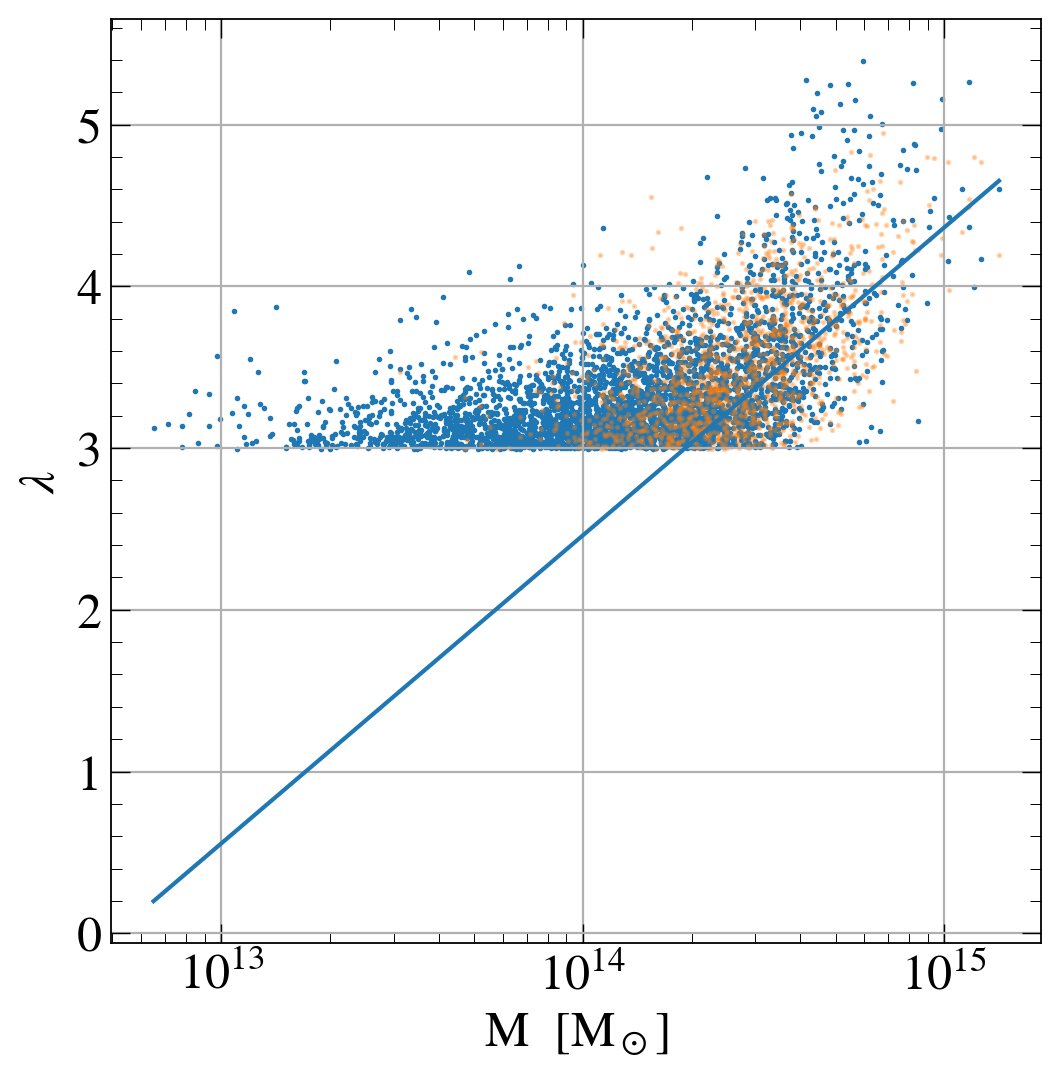

In [12]:
plot_data_vs_monte_carlo_points(intercept=res.x[0], slope=res.x[1], sigma0=res.x[2], qlam=res.x[3])

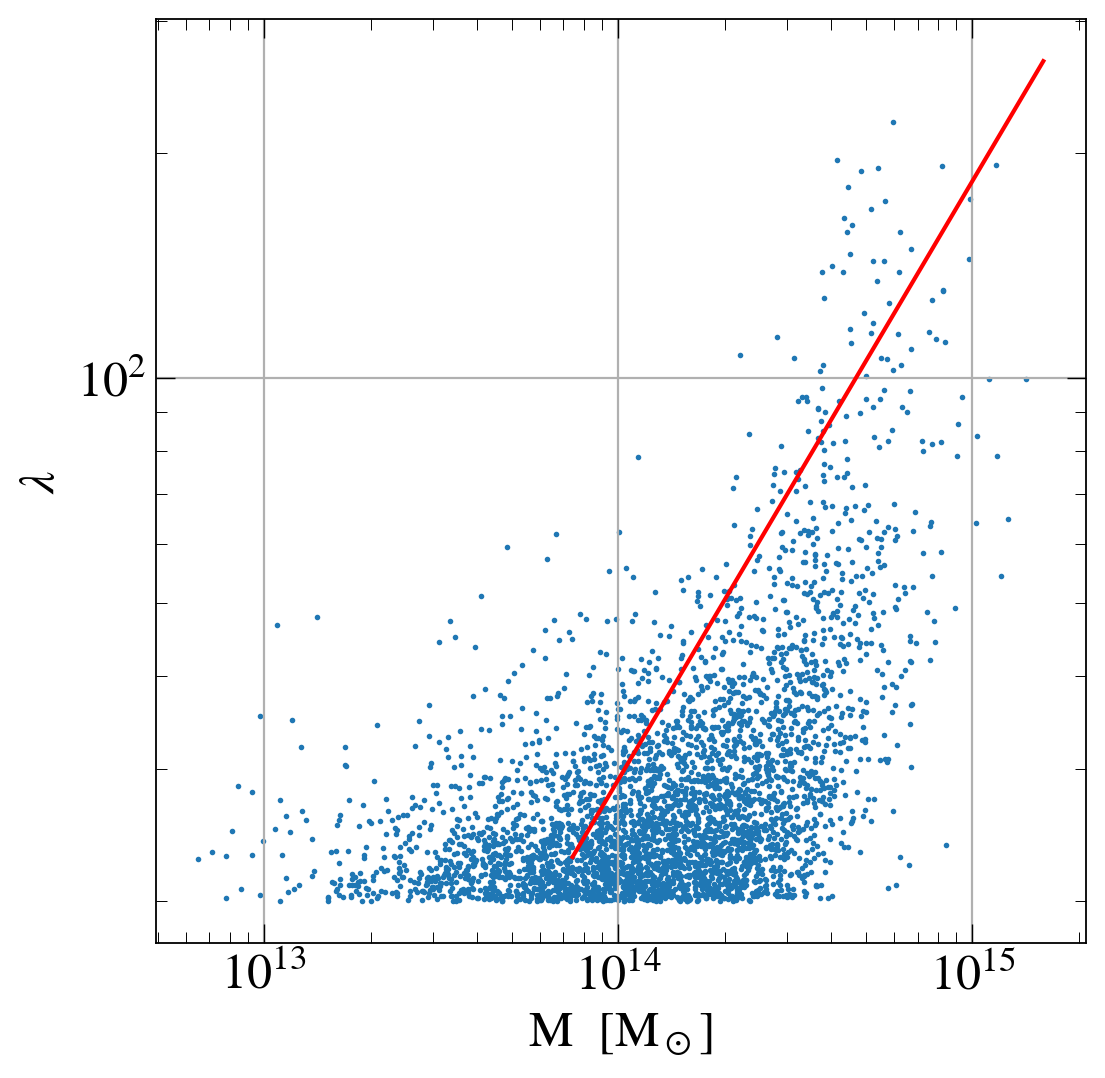

In [13]:
# plot richness-mass relation with a lambda 20 cut
lnMpivot = np.log(3e14)
lnlamth = np.log(20)

lnlam = np.log(lam)
ndata = len(lnM_all)


def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam):
    plt.scatter(np.exp(lnM_all), np.exp(lnlam), s=1)
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    # plt.scatter(lnM_mc, lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(25, 35)
    lambd = np.exp(intercept + slope * (lnM_plot - lnMpivot))
    sel = lambd>=20
    lambd = lambd[sel]
    lnM_plot = lnM_plot[sel]
    plt.plot(np.exp(lnM_plot), lambd, c='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'M  [$\rm M_\odot$]')
    plt.ylabel(r'$\lambda$')

# make a guess for starting points
plot_data_vs_monte_carlo_points(intercept=np.log(70), slope=0.8, sigma0=0.3, qlam=-0.09)

# plt.savefig('Images/mass_richness.png', facecolor='white')

In [14]:
### Halos--RedMaPPer
clusterrun_halo = Table(np.load(filepath+'HaloRun_Halo_Clusters_Lamgt20-20110.npy'))  #'HaloRun_Halo_Clusters_Lamgt20-20110.npy'
print(len(clusterrun_halo))
clusterrun_halo = clusterrun_halo['m200','ra','dec','z','mem_match_id','lambda']
clusterrun_halo = clusterrun_halo.to_pandas()

zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65)] #, (0.65, 0.8)
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]'] #,'(0.65, 0.8]'
clusterrun_halo['redshift_range'] = pd.cut(clusterrun_halo['z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)

# Group by redshift_range
grouped_datarun = clusterrun_halo.groupby('redshift_range', observed=False)

20110


20110
[ 3.          1.0191038   0.46053763 -0.0867963 ]
[ 3.3682488   0.82639813  0.42363355 -0.07254834]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 3.22933231  0.7073226   0.4579697  -0.05867113]


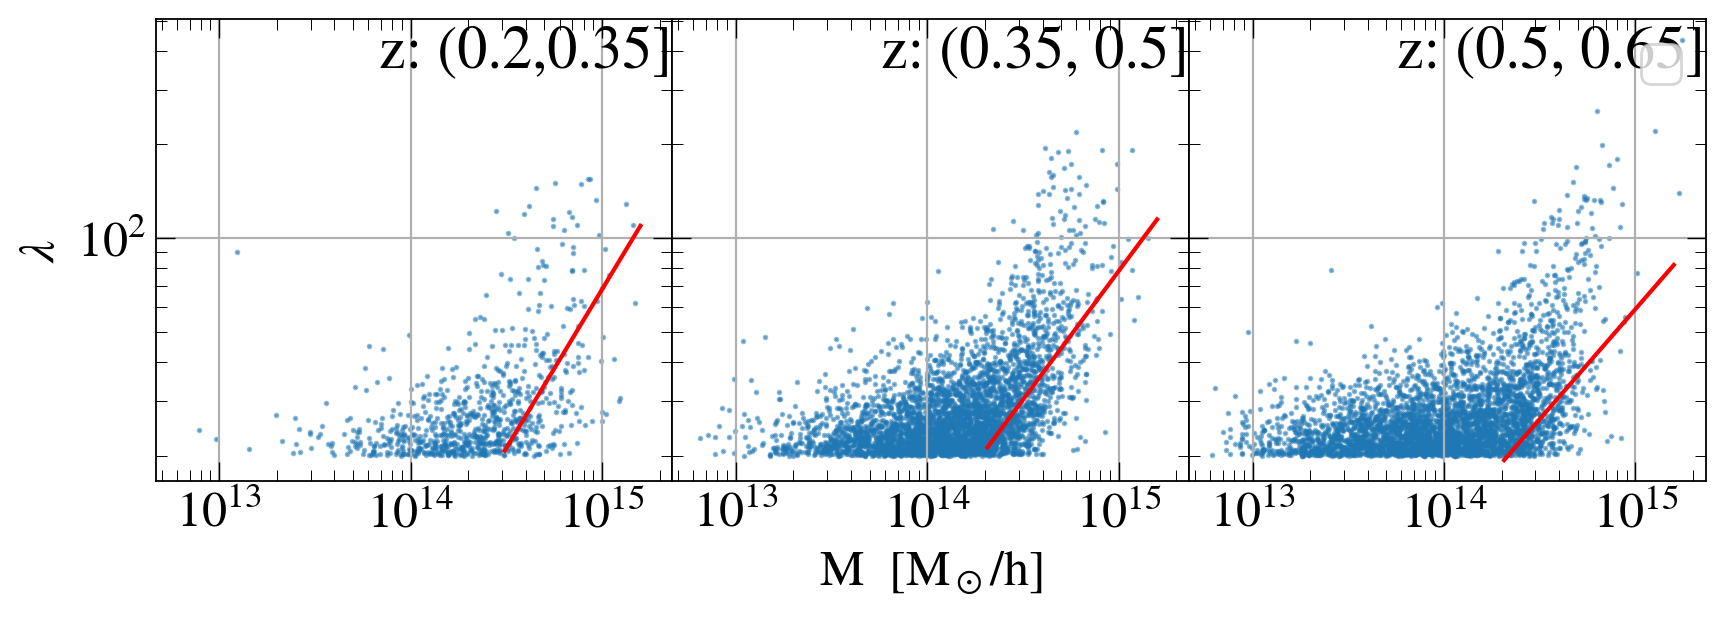

In [54]:
### Halos--RedMaPPer  ### Halo-Cluster_Matching/halo_cluster_ShuleiMasked.npy
cluster_halo2 = Table(np.load(filepath+'HaloRun_Halo_Clusters_Lamgt20-20110.npy'))  #'HaloRun_Halo_Clusters_Lamgt20-20110.npy'
print(len(cluster_halo2))
cluster_halo2 = cluster_halo2['m200','ra','dec','z','mem_match_id','lambda']
cluster_halo2 = cluster_halo2.to_pandas()

cluster_halo2['redshift_range'] = pd.cut(cluster_halo2['z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)

# Group by redshift_range
grouped_data = cluster_halo2.groupby('redshift_range', observed=False)
cluster_halo2
# # Create four subplots
fig, axs = plt.subplots(1, 3,figsize=(10, 3), sharex=True, sharey=True)
axs = axs.flatten()

def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam, lnM_all, lnlam):
    ax.scatter(np.exp(lnM_all), np.exp(lnlam), s=1, alpha=0.5)
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    
    lnM_plot = np.linspace(25, 35)
    lambd = np.exp(intercept + slope * (lnM_plot - lnMpivot))
    sel = lambd>=19
    lambd = lambd[sel]
    lnM_plot = lnM_plot[sel]
    ax.plot(np.exp(lnM_plot), lambd, c='red')

# Iterate over the groups and plot the data
for i, group in enumerate(grouped_data.groups.keys()):
    ax = axs[i]
    cl_halo_hr = grouped_datarun.get_group(group)
    mass_hr = np.array(np.log(cl_halo_hr['m200']))
    richness_hr = np.array(np.log(cl_halo_hr['lambda']))
    res_hr = minimize(negative_lnlikelihood_total, x0, args=(richness_hr, mass_hr), bounds=bounds)
    plot_data_vs_monte_carlo_points(intercept=res_hr.x[0], slope=res_hr.x[1], sigma0=res_hr.x[2], qlam=res_hr.x[3], lnM_all=mass_hr, lnlam=richness_hr)
    print(res_hr.x)

    # Set the title inside the subplot
    title = f'z: {group}'
    title_y = 0.859 if i > 1 else 0.859  # Adjust the y position for the last row
    ax.set_title(title,  loc='right', y=title_y)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axs[[1]]:
    ax.set_xlabel(r'M  [$ \rm M_\odot/h$]')
    
for ax in axs[[0]]:
    ax.set_ylabel('$\lambda$')
plt.legend()    
filep = r'/bsuhome/gladyskamau/BSU-Research/Cardinal/'
plt.savefig(filep + 'Images/cardinal_mass-richness.png', facecolor='white')
plt.show()

### hexabin plot of the richness--mass relation

20110
[ 3.          1.01913217  0.46053168 -0.08681887]
[ 3.36848944  0.8271249   0.42336546 -0.07303019]
[ 3.23129048  0.71020277  0.45671627 -0.06024849]


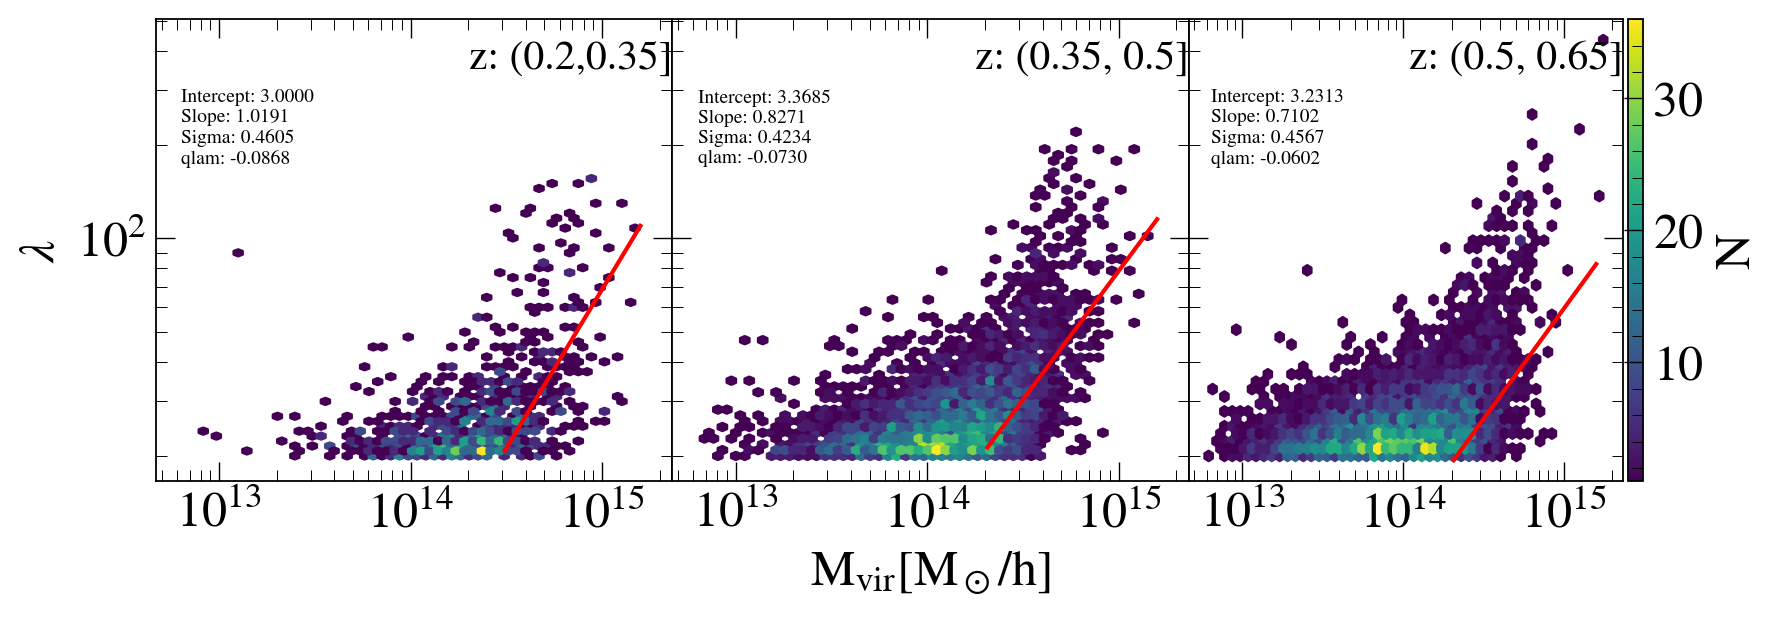

In [20]:
### Halos--RedMaPPer  ### Halo-Cluster_Matching/halo_cluster_ShuleiMasked.npy
cluster_halo2 = Table(np.load(filepath+'HaloRun_Halo_Clusters_Lamgt20-20110.npy'))  #'HaloRun_Halo_Clusters_Lamgt20-20110.npy'
print(len(cluster_halo2))
cluster_halo2 = cluster_halo2['m200','ra','dec','z','mem_match_id','lambda']
cluster_halo2 = cluster_halo2.to_pandas()
# cluster_halo2 = cluster_halo2.reset_index(drop=True)

cluster_halo2['redshift_range'] = pd.cut(cluster_halo2['z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
# grouped = cluster_halo3.groupby('redshift_range')

# Group by redshift_range
grouped_data = cluster_halo2.groupby('redshift_range', observed=False)
cluster_halo2
# # Create four subplots
fig, axs = plt.subplots(1, 3,figsize=(10, 3), sharex=True, sharey=True)
axs = axs.flatten()

def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam, lnM_all, lnlam):
    hb = ax.hexbin(np.exp(lnM_all),np.exp(lnlam), gridsize=50, cmap='viridis', mincnt=1, yscale='log', xscale='log')
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    # plt.scatter(lnM_mc, lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(25, 35)
    lambd = np.exp(intercept + slope * (lnM_plot - lnMpivot))
    sel = lambd>=19
    lambd = lambd[sel]
    lnM_plot = lnM_plot[sel]
    ax.plot(np.exp(lnM_plot), lambd, c='r', label='best-fit')
    return hb

# Iterate over the groups and plot the data
for i, group in enumerate(grouped_data.groups.keys()):
    ax = axs[i]
    cl_halo_hr = grouped_datarun.get_group(group)
    mass_hr = np.array(np.log(cl_halo_hr['m200']))
    richness_hr = np.array(np.log(cl_halo_hr['lambda']))
    res_hr = minimize(negative_lnlikelihood_total, x0, args=(richness_hr, mass_hr), bounds=bounds)
    intercept = res_hr.x[0]
    slope = res_hr.x[1]
    sigma0 = res_hr.x[2]
    qlam = res_hr.x[3]
    hb = plot_data_vs_monte_carlo_points(intercept=res_hr.x[0], slope=res_hr.x[1], sigma0=res_hr.x[2], qlam=res_hr.x[3], lnM_all=mass_hr, lnlam=richness_hr)
    print(res_hr.x)
    
        # Add best-fit parameters as text
    textstr = '\n'.join((
        r'Intercept: %.4f' % (intercept),
        r'Slope: %.4f' % (slope),
        r'Sigma: %.4f' % (sigma0),
        r'qlam: %.4f' % (qlam)))
    
    props = dict(boxstyle='round', facecolor='white', alpha=0)
    ax.text(0.05, 0.85, textstr, transform=ax.transAxes, fontsize=7,
            verticalalignment='top', bbox=props)
    
    # Set the title inside the subplot
    title = f'z: {group}'
    title_y = 0.859 if i > 1 else 0.859  # Adjust the y position for the last row
    ax.set_title(title,  loc='right', y=title_y, fontsize=15)
    ax.grid(visible=False)

# Add color bar at the end of the plot on the right
cbar = fig.colorbar(hb, ax=axs[2], location='right', pad=0.01, aspect=30)
cbar.set_label(r'N')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axs[[1]]:
    ax.set_xlabel(r'$ \rm M_{vir}  [ M_\odot/h$]')
    
for ax in axs[[0]]:
    ax.set_ylabel('$\lambda$')
# plt.legend()    
filep = r'/bsuhome/gladyskamau/BSU-Research/Cardinal/'
plt.savefig(filep + 'Images/cardinal_mass-richness_hex.png', facecolor='white')
plt.show()

# Halo-run match  (Halos matched to the halo-run catalog) vs Shulei's matching method 

In [21]:
### Halos--RedMaPPer  ### Halo-Cluster_Matching/halo_cluster_ShuleiMasked.npy
clusterrun_halo = Table(np.load(filepath+'HaloRun_Halo_Clusters_Lamgt20-20110.npy'))  #'HaloRun_Halo_Clusters_Lamgt20-20110.npy'
print(len(clusterrun_halo))
clusterrun_halo = clusterrun_halo['m200','ra','dec','z','mem_match_id','lambda']
clusterrun_halo = clusterrun_halo.to_pandas()

zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65)] #, (0.65, 0.8)
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]'] #,'(0.65, 0.8]'
clusterrun_halo['redshift_range'] = pd.cut(clusterrun_halo['z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)

# Group by redshift_range
grouped_datarun = clusterrun_halo.groupby('redshift_range', observed=False)

20110


15750
[ 3.          1.04729525  0.45458636 -0.10136333] [ 3.          1.01913217  0.46053168 -0.08681887]
[ 3.30988938  0.90806179  0.44259211 -0.11962982] [ 3.36848944  0.8271249   0.42336546 -0.07303019]
[ 3.18680923  0.80049889  0.44851077 -0.12900527] [ 3.23129048  0.71020277  0.45671627 -0.06024849]


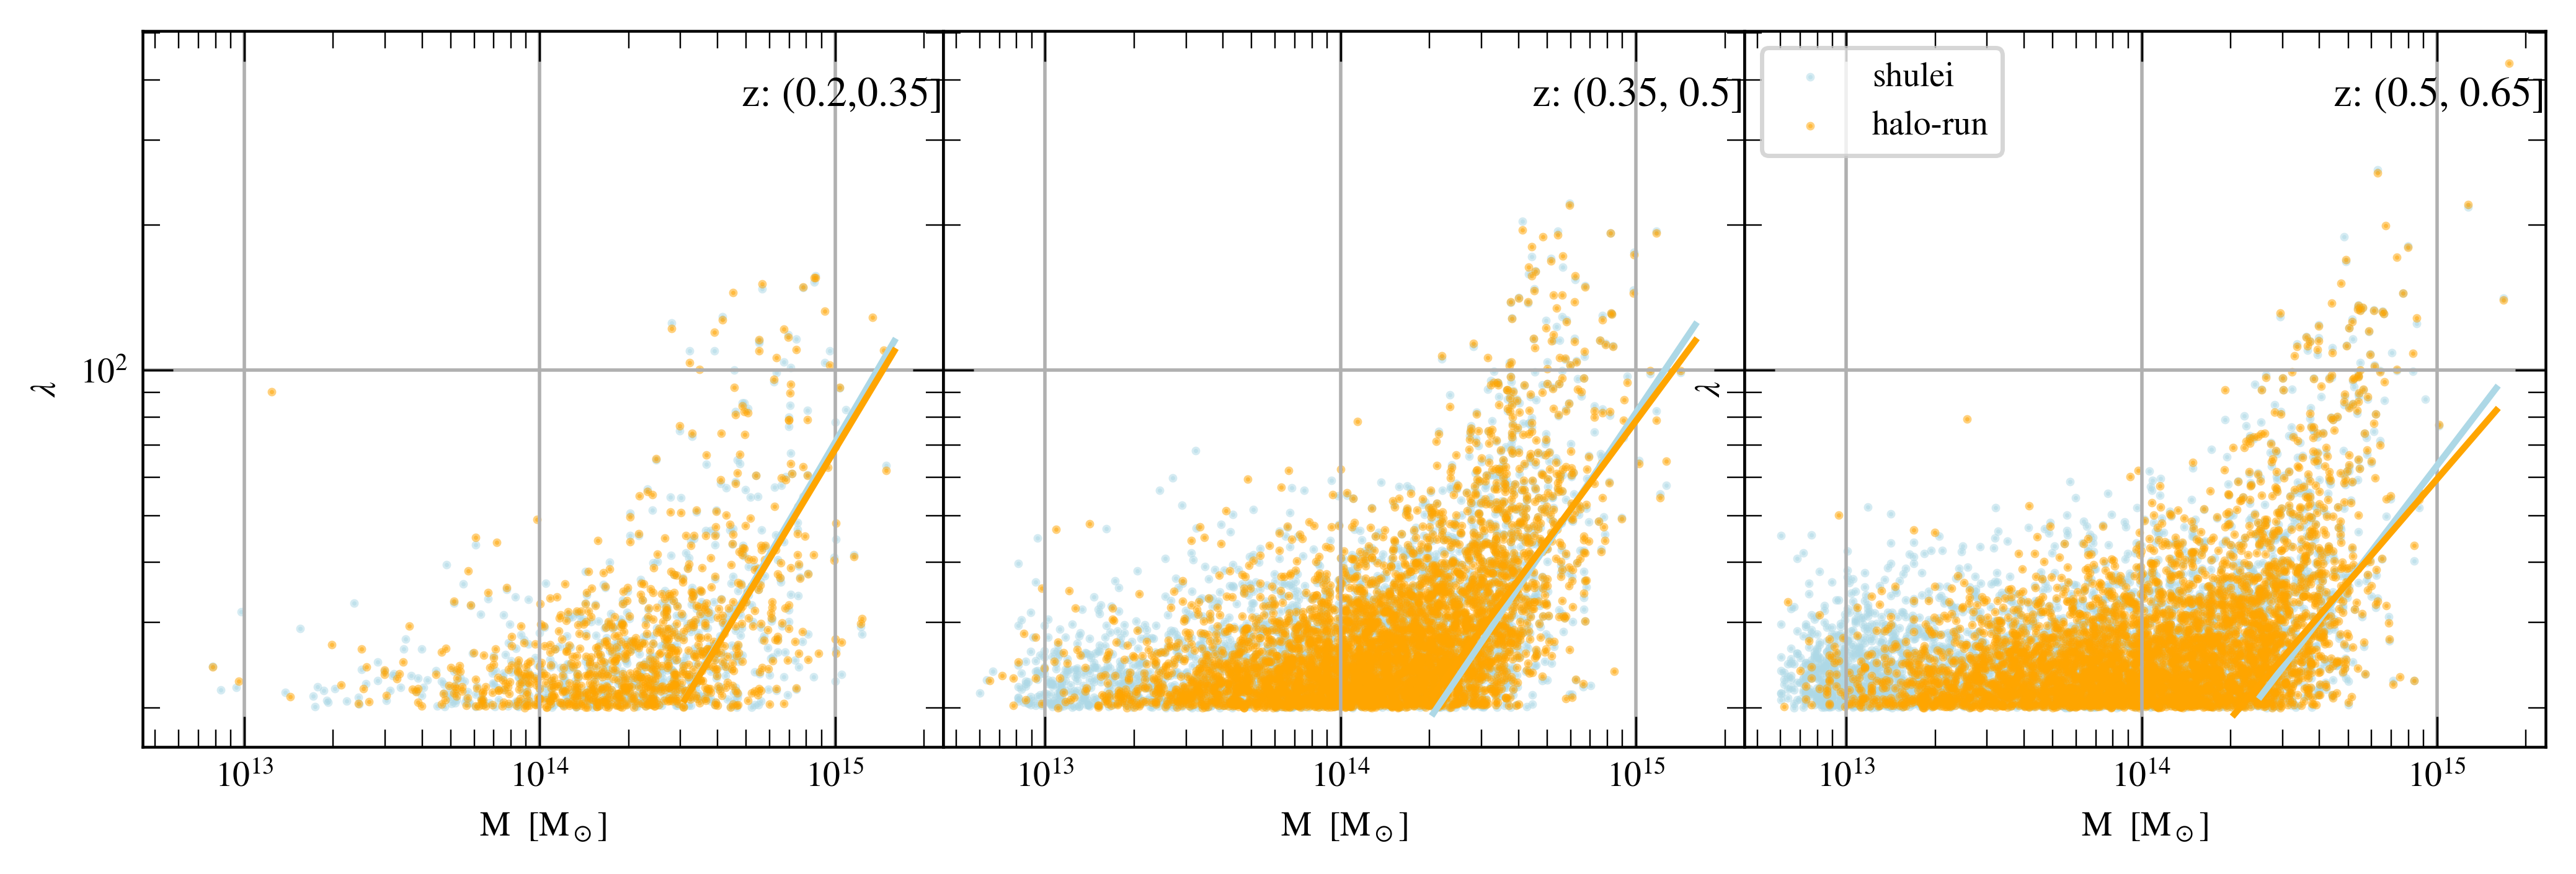

In [27]:
## Comparing Shulei's and Halo-run
### Halos--RedMaPPer  ### Halo-Cluster_Matching/halo_cluster_ShuleiMasked.npy
cluster_halo2 = Table(np.load(filepath+'Halo-Cluster_Matching/halo_cluster_ShuleiMasked.npy'))  #'HaloRun_Halo_Clusters_Lamgt20-20110.npy'
print(len(cluster_halo2))
cluster_halo2 = cluster_halo2['m200','ra','dec','z','mem_match_id','lambda']
cluster_halo2 = cluster_halo2.to_pandas()
# cluster_halo2 = cluster_halo2.reset_index(drop=True)

cluster_halo2['redshift_range'] = pd.cut(cluster_halo2['z'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
# grouped = cluster_halo3.groupby('redshift_range')

# Group by redshift_range
grouped_data = cluster_halo2.groupby('redshift_range', observed=False)
cluster_halo2
# # Create four subplots
fig, axs = plt.subplots(1, 3,figsize=(10, 3), sharex=True, sharey=True, dpi=500)
axs = axs.flatten()

def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam, lnM_all, lnlam, colour,lbl):
    ax.scatter(np.exp(lnM_all), np.exp(lnlam), s=1, alpha=0.5, c = colour, label=lbl)
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    # plt.scatter(lnM_mc, lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(25, 35)
    lambd = np.exp(intercept + slope * (lnM_plot - lnMpivot))
    sel = lambd>=19
    lambd = lambd[sel]
    lnM_plot = lnM_plot[sel]
    ax.plot(np.exp(lnM_plot), lambd, c=colour)

# Iterate over the groups and plot the data
for i, group in enumerate(grouped_data.groups.keys()):
    ax = axs[i]
    cl_halo_shulei = grouped_data.get_group(group)
    cl_halo_hr = grouped_datarun.get_group(group)
    mass_shulei = np.array(np.log(cl_halo_shulei['m200']))
    mass_hr = np.array(np.log(cl_halo_hr['m200']))
    richness_shulei = np.array(np.log(cl_halo_shulei['lambda']))
    richness_hr = np.array(np.log(cl_halo_hr['lambda']))
    res_s = minimize(negative_lnlikelihood_total, x0, args=(richness_shulei, mass_shulei), bounds=bounds)
    res_hr = minimize(negative_lnlikelihood_total, x0, args=(richness_hr, mass_hr), bounds=bounds)
    plot_data_vs_monte_carlo_points(intercept=res_s.x[0], slope=res_s.x[1], sigma0=res_s.x[2], qlam=res_s.x[3], lnM_all=mass_shulei, lnlam=richness_shulei, colour='lightblue',lbl='shulei')
    plot_data_vs_monte_carlo_points(intercept=res_hr.x[0], slope=res_hr.x[1], sigma0=res_hr.x[2], qlam=res_hr.x[3], lnM_all=mass_hr, lnlam=richness_hr, colour='orange',lbl='halo-run')
    print(res_s.x, res_hr.x)

    # Set the title inside the subplot
    title = f'z: {group}'
    title_y = 0.859 if i > 1 else 0.859  # Adjust the y position for the last row
    ax.set_title(title,  loc='right', y=title_y)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axs:
    ax.set_xlabel(r'$ \rm M_{vir}  [ M_\odot/h$]')
for ax in axs[[0, 2]]:
    ax.set_ylabel('$\lambda$')
plt.legend()    
# plt.savefig('Images/mass_richness.png', facecolor='white')
plt.show()

In [33]:
halo_run = np.array([[ 3.000e+00,  1.019e+00,  4.605e-01, -8.682e-02],
           [ 3.368e+00,  8.271e-01,  4.234e-01, -7.303e-02],
           [ 3.231e+00,  7.102e-01,  4.567e-01, -6.025e-02]])
shulei = np.array([[ 3.000e+00,  1.047e+00,  4.546e-01, -1.014e-01],
                  [ 3.310e+00,  9.081e-01,  4.426e-01, -1.196e-01],
                   [ 3.187e+00 , 8.005e-01,  4.485e-01, -1.290e-01]])

names = ['intercept', 'slope', 'sigma0', 'qlam']
z_bins = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]']
halo_run_parameters1 = Table(data=halo_run, names=names)
shulei_parameters2 = Table(data=shulei, names=names)

In [34]:
from astropy.table import hstack, vstack

params_full = hstack([halo_run_parameters1, shulei_parameters2])
params_full['z_bins'] = z_bins
params_full.rename_columns(['intercept_1','slope_1','sigma0_1','qlam_1','intercept_2','slope_2','sigma0_2','qlam_2'],
                          ['intercept_hr','slope_hr','sigma0_hr','qlam_hr','intercept_s','slope_s','sigma0_s','qlam_s'])
params_full

intercept_hr,slope_hr,sigma0_hr,qlam_hr,intercept_s,slope_s,sigma0_s,qlam_s,z_bins
float64,float64,float64,float64,float64,float64,float64,float64,str11
3.0,1.019,0.4605,-0.08682,3.0,1.047,0.4546,-0.1014,"(0.2,0.35]"
3.368,0.8271,0.4234,-0.07303,3.31,0.9081,0.4426,-0.1196,"(0.35, 0.5]"
3.231,0.7102,0.4567,-0.06025,3.187,0.8005,0.4485,-0.129,"(0.5, 0.65]"


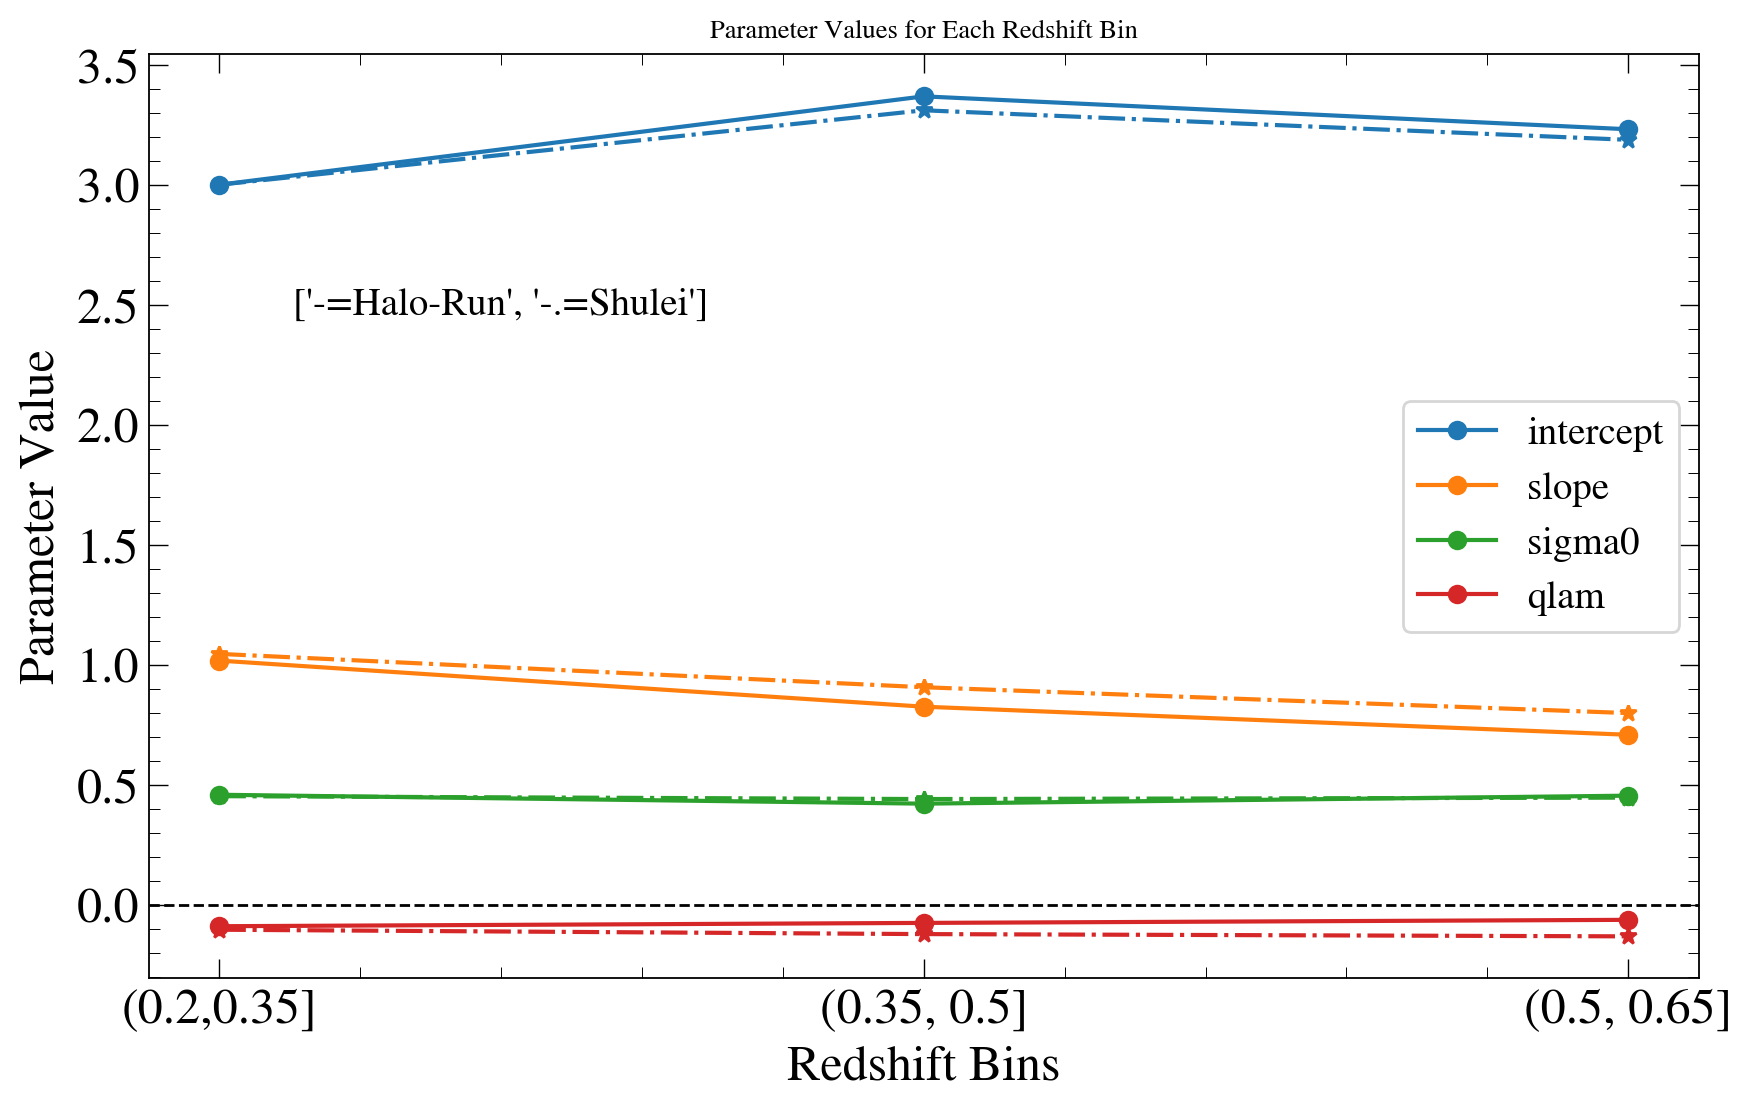

In [13]:
# Transpose the table
halo_run_parameters_transposed1 = Table({name: halo_run_parameters1[name] for name in names})
halo_run_parameters_transposed2 = Table({name: halo_run_parameters2[name] for name in names})

# Line plot for each parameter
plt.figure(figsize=(10, 6))

# Line positions
x = np.arange(len(z_bins))

# Get the default colors for the legend
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot lines for each field with linestyle based on legend colors
for i, (field_name, color) in enumerate(zip(halo_run_parameters_transposed1.columns, colors)):
    plt.plot(x, halo_run_parameters_transposed1[field_name], label=f'{field_name}', color=color, marker='o')
    plt.plot(x, halo_run_parameters_transposed2[field_name], color=color, linestyle='-.', marker='*')
    
plt.axhline(0, color='black', linestyle='--', linewidth=1)

lines = ['-=Halo-Run', '-.=Shulei']

plt.text(0.4, 2.5, f'{lines}', ha='center', va='center', fontsize=14)

# Add labels and title
plt.xlabel('Redshift Bins', fontsize=18)
plt.ylabel('Parameter Value', fontsize=18)
plt.title('Parameter Values for Each Redshift Bin')
plt.xticks(x, z_bins, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize=14)

# Remove grid lines
plt.grid(False)

# Show or save the plot
plt.show()


# HaloRun halos 

In [22]:
## Sigma and DS profile that have a match in Gold catalog
# halos =  Table(np.load(filepath+"halos_cardinal_w_lensing_1687.npy"))
## Halos from gold catalog having Mvir greater than 0
halos = Table(np.load(filepath + "halos_Mvirgreatthan0_3025241.npy"))
print(len(halos))
halos[:2]

3025241


haloid,ra,dec,Mvir,cos_z,coadd_object_id
int64,float32,float32,float32,float64,int64
10259160,45.042305,0.036648054,9980000000000.0,0.12279979938300123,364000000749
34071991,45.02364,0.04881371,11860000000000.0,0.6781063889839549,364004949061


In [23]:
'{:e}'.format(halos['Mvir'].min())

'6.010000e+12'

In [24]:
halos = halos[(halos['cos_z']>=0.2) & (halos['cos_z']<=0.65)]

zranges = [(0.2, 0.21), (0.35, 0.36), (0.5, 0.51)]
zlabels = ['(0.2,0.21]', '(0.35, 0.36]', '(0.5, 0.51]']
halos['redshift_range'] = pd.cut(halos['cos_z'], bins=pd.IntervalIndex.from_tuples(zranges), labels=zlabels)

def is_nan(val):
    return isinstance(val, float) and np.isnan(val)

sky_02_1_2 = clean_table = halos[[not is_nan(val) for val in halos['redshift_range']]]
print(len(sky_02_1_2))
sky_02_1_2[:2]

61044


haloid,ra,dec,Mvir,cos_z,coadd_object_id,redshift_range
int64,float32,float32,float32,float64,int64,object
24160690,44.962692,0.18621576,6984000000000.0,0.5084550159893222,364002803923,"(0.5, 0.51]"
24151719,45.12449,0.29786593,7958000000000.0,0.5054490596013073,364002803585,"(0.5, 0.51]"


In [25]:
'{:e}'.format(sky_02_1_2['Mvir'].min())

'6.010000e+12'

/tmp/ipykernel_234810/2046069190.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20')  # Choose a colormap


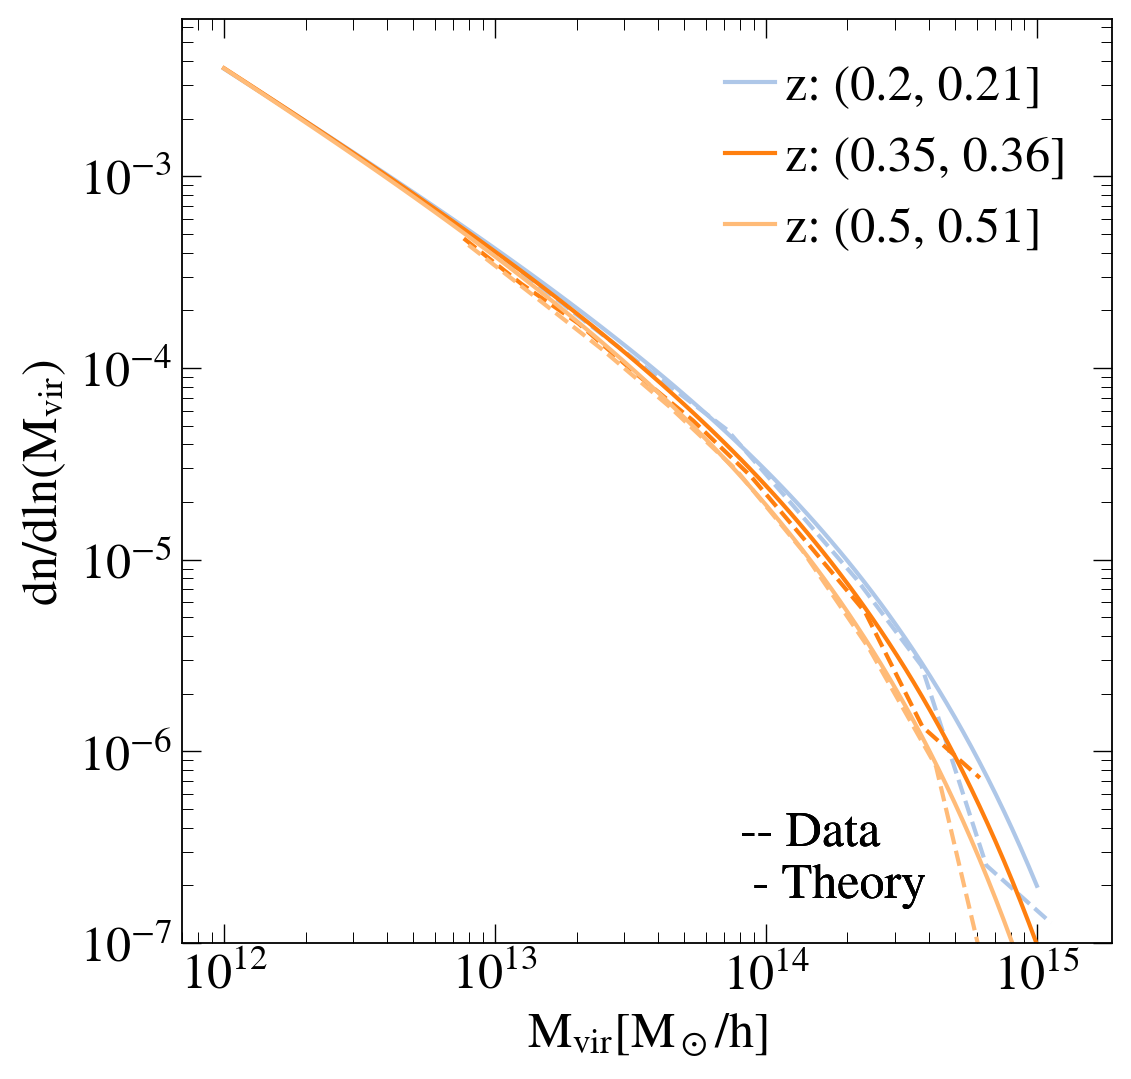

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import re
from colossus.lss import mass_function
from matplotlib import cm

grouped_data = sky_02_1_2.group_by('redshift_range')

# Choose a colormap
color_map = cm.get_cmap('tab20')  # Choose a colormap
idx = 0
# Iterate over the groups and plot the data
for group, data in zip(grouped_data.groups.keys['redshift_range'], grouped_data.groups):
    idx +=1
    group = str(group)  # Convert group to string if needed
    zmin = float(re.findall(r'\d+\.\d+', group)[0])
    zmax = float(re.findall(r'\d+\.\d+', group)[1])
    vol_hiMpc3 = (5000 / (4 * np.pi * ((180 / np.pi) ** 2))) * (4 * np.pi / 3) * (
            (cosmo.comovingDistance(z_max=zmax)) ** 3 - (cosmo.comovingDistance(z_max=zmin)) ** 3)
    M200c = data['Mvir']
    lnM_all = np.array(np.log(M200c))
    counts, bins = np.histogram(lnM_all)
    bins_mid = (bins[1:] + bins[:-1]) / 2.
    counts = counts / (bins[1] - bins[0])
    vol = vol_hiMpc3
    color = color_map(idx % color_map.N)  # Get a color from the colormap

    plt.plot(np.exp(bins_mid), (counts / vol), color=color, linestyle='--')

    redshift = data['cos_z'].mean() #data['redshift'].max()+0.035
    M_plot = np.logspace(12, 15, 100)
    mfunc_200c = mass_function.massFunction(M_plot, redshift, q_out='dndlnM',
                                            mdef='vir', model='tinker08')
    plt.plot(M_plot, mfunc_200c, color=color, label='z')

    # Add text description
    text = f'-- Data \n - Theory'
    plt.text(0.6, 0.05, text, transform=plt.gca().transAxes)

# Set custom labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
group_keys = grouped_data.groups.keys['redshift_range'].tolist()  # Convert keys to list
custom_labels = [f'{label}: {group}' for label, group in zip(labels, group_keys)]


plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-7)
plt.xlabel(r'$ \rm M_{vir}  [ M_\odot/h$]')
plt.ylabel('$\mathrm{dn/d\ln(M_{vir}})$')
plt.legend(handles, custom_labels, loc='best', frameon=False,handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)
plt.grid(visible=False)
filep = r'/bsuhome/gladyskamau/BSU-Research/Cardinal/'
plt.savefig(filep + 'Images/cardinal_HaloMassFxn.png', facecolor='white')
plt.show()
